In [25]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_array
from scipy.sparse.csgraph import dijkstra
import matplotlib.pyplot as plt

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from functions import static_assignment_fw
from functions import *
from plot import plot_network

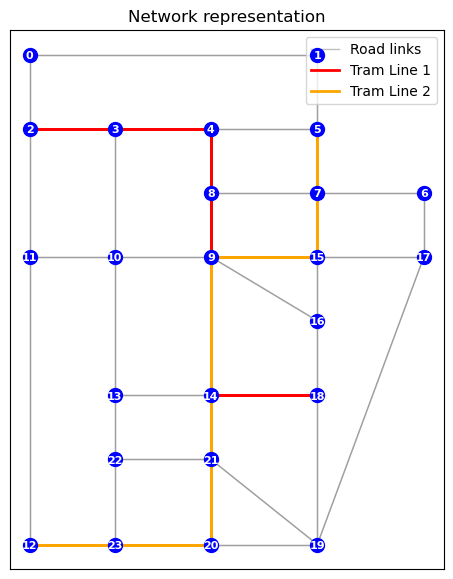

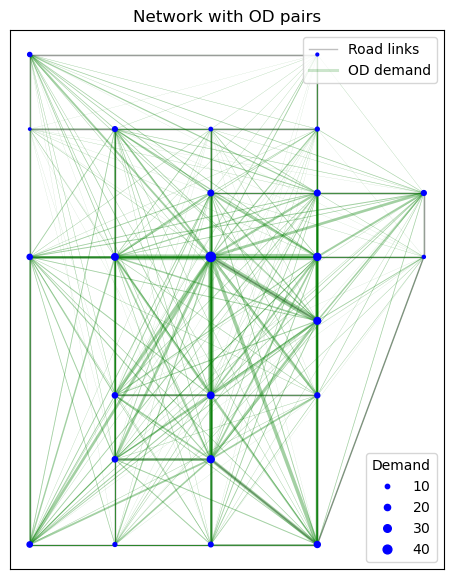

In [35]:
# load network
df_od = pd.read_csv('sf/sf_od.csv')
df_node = pd.read_csv('sf/sf_node.csv')
df_link = pd.read_csv('sf/sf_link.csv')
df_link_tram = pd.read_csv('sf/sf_link_tram.csv')

plot_network(df_node, df_link, df_link_tram)
plt.savefig("Latex/Figures/network.pgf")
plot_network(df_node, df_link, df_od=df_od)
plt.savefig("Latex/Figures/od_pairs.pgf")

In [5]:
# define cost function
def BPR_cost_function(df_link, x):
    return df_link.t0 * (1 + 0.15 * ((x/df_link.saturation)**4))

# define objective function
def Beckmann_obj_function(df_link, x):
    return (df_link.t0 * x * (1 + 0.03 * (x / df_link.saturation)**4)).sum()

In [ ]:
# first run with recommended parameters
max_iter, max_gap, max_gap_ls = 2000, 1e-4, 1e-2
x_star0, _, gap, obj = static_assignment_fw(df_od, df_link, df_link_tram, max_iter, max_gap, cost_function=BPR_cost_function, objective_function=Beckmann_obj_function)

print(f"Stopped after {len(gap)}/{max_iter} iterations, final gap : {gap[-1]}/{max_gap}, final obj value : {obj[-1]}")

np.save("x_star0", x_star0)

Gap: 0.0002069 - Objective: 42.3179:  52%|█████▏    | 1048/2000 [12:51<11:40,  1.36it/s] 

Stopped after 1049/2000 iterations, final gap : 9.882287363008393e-05/0.0001, final obj value : 42.317891730503035


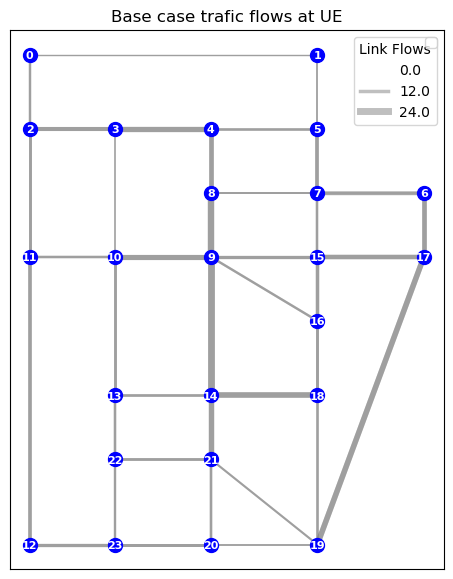

In [36]:
plot_network(df_node, df_link, link_flows=x_star0, title="Base case trafic flows at UE")

plt.savefig("Latex/Figures/basecase.pgf")

In [45]:
# run with tram (level=1)
max_iter, max_gap, max_gap_ls = 2000, 1e-4, 1e-2
x_star1, x_tram1, gap, obj = static_assignment_fw(df_od, df_link, df_link_tram, max_iter, max_gap, cost_function=BPR_cost_function, objective_function=Beckmann_obj_function, restriction_level=1)

print(f"Stopped after {len(gap)}/{max_iter} iterations, final gap : {gap[-1]}/{max_gap}, final obj value : {obj[-1]}")

np.save("x_star1", x_star1)
np.save("x_tram1", x_tram1)

Gap: 0.0001177 - Objective: 29.3050:   9%|▉         | 189/2000 [01:45<16:51,  1.79it/s]

Stopped after 190/2000 iterations, final gap : 9.043125911658922e-05/0.0001, final obj value : 29.305497982012632


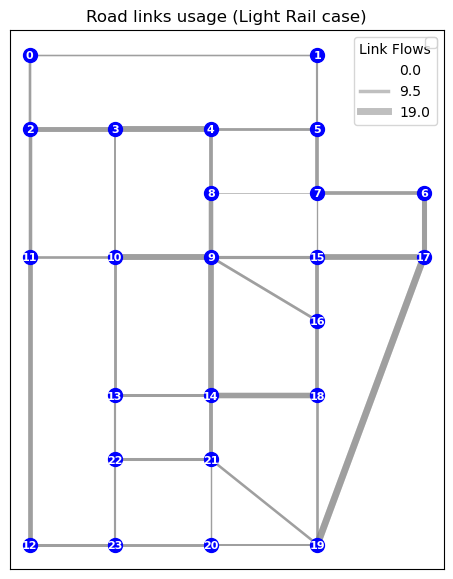

In [66]:
plot_network(df_node, df_link, link_flows=x_star1, title="Road links usage (Light Rail case)")
plt.savefig("Latex/Figures/lightrail_road.pgf", bbox_inches = "tight")

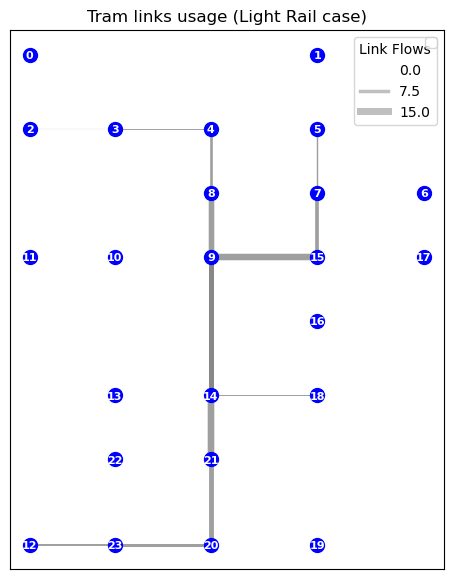

In [67]:
plot_network(df_node, df_link_tram, link_flows=x_tram1, title="Tram links usage (Light Rail case)")
plt.savefig("Latex/Figures/lightrail_tram.pgf", bbox_inches = "tight")

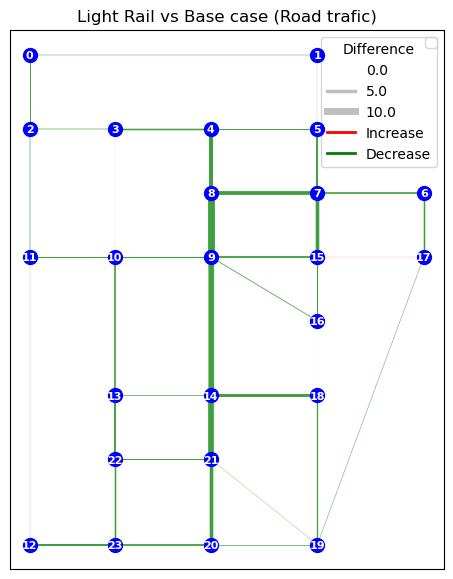

In [88]:
plot_network(df_node, df_link, link_flows=x_star1-x_star0, title="Light Rail vs Base case (Road trafic)")
plt.savefig("Latex/Figures/lightrail_diff.pgf", bbox_inches = "tight")

In [57]:
# run with tram (level=2)
max_iter, max_gap, max_gap_ls = 2000, 1e-4, 1e-2
x_star2, x_tram2, gap, obj = static_assignment_fw(df_od, df_link, df_link_tram, max_iter, max_gap, cost_function=BPR_cost_function, objective_function=Beckmann_obj_function, restriction_level=2)

print(f"Stopped after {len(gap)}/{max_iter} iterations, final gap : {gap[-1]}/{max_gap}, final obj value : {obj[-1]}")

np.save("x_star2", x_star2)
np.save("x_tram2", x_tram2)

Gap: 0.000196 - Objective: 24.9233:  18%|█▊        | 368/2000 [08:59<39:51,  1.47s/it]   

Stopped after 369/2000 iterations, final gap : 9.576207572274547e-05/0.0001, final obj value : 24.92420246537671


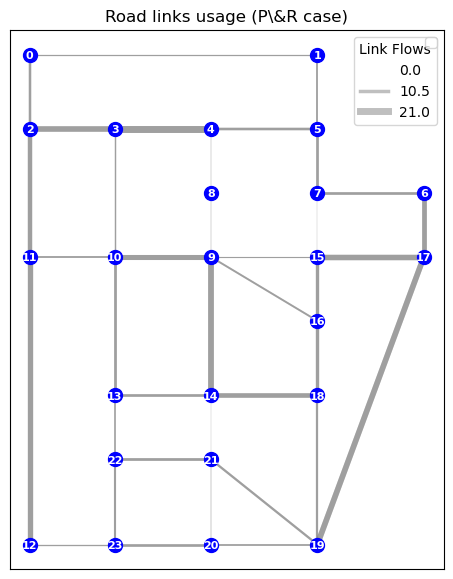

In [58]:
plot_network(df_node, df_link, link_flows=x_star2, title="Road links usage (P\\&R case)")
plt.savefig("Latex/Figures/PnR_road.pgf", bbox_inches = "tight")

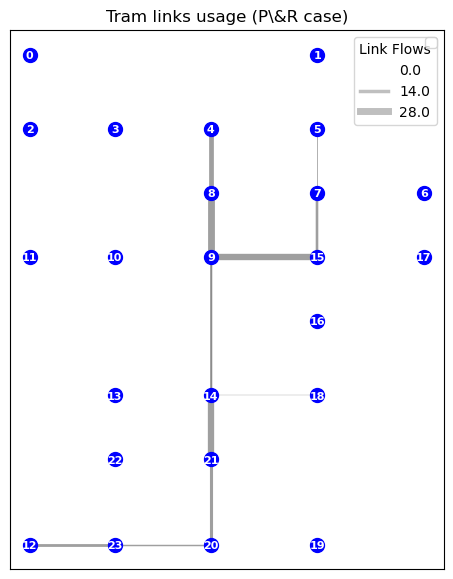

In [81]:
plot_network(df_node, df_link_tram, link_flows=x_tram2, title="Tram links usage (P\\&R case)")
plt.savefig("Latex/Figures/PnR_tram.pgf", bbox_inches = "tight")

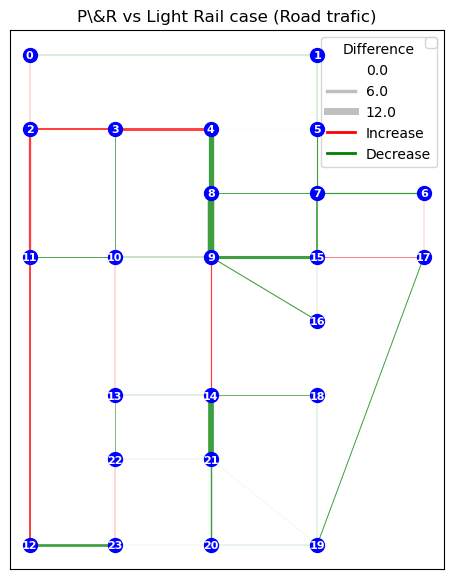

In [86]:
plot_network(df_node, df_link, link_flows=x_star2-x_star1, title="P\\&R vs Light Rail case (Road trafic)")
plt.savefig("Latex/Figures/PnR_diff_road.pgf", bbox_inches = "tight")

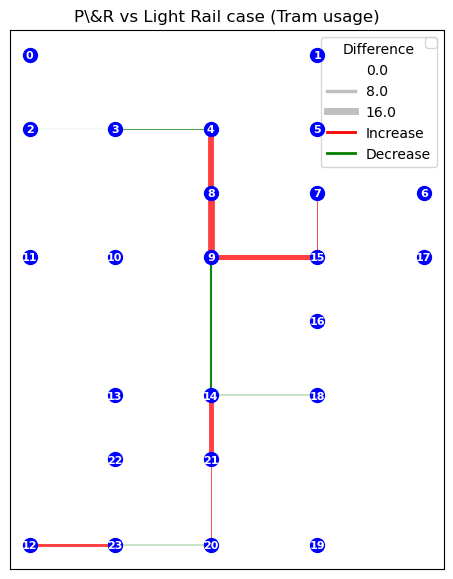

In [85]:
plot_network(df_node, df_link_tram, link_flows=x_tram2-x_tram1, title="P\\&R vs Light Rail case (Tram usage)")
plt.savefig("Latex/Figures/PnR_diff_tram.pgf", bbox_inches = "tight")

! Add total travel time improvement

distances: https://maps.app.goo.gl/8aV33hSoMT5dqdGJ6 (line 2)
https://maps.app.goo.gl/vfXk5ZgF1G3eepJu7 (line 1)

In [79]:
df_link_tram = pd.read_csv('sf/sf_link_tram.csv')
df_link_tram["time"] = df_link_tram["distance"] / 25 * 60# 25 miles/hour
df_link_tram["cost"] = df_link_tram["time"] / 60 #t_0 is in hours
df_link_tram.to_csv('sf/sf_link_tram.csv', index=False)